In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%config InlineBackend.figure_format = 'retina'
#az.style.use('arviz-darkgrid')
sns.set_style('darkgrid')

# PAR with synthetic data

In [3]:
N = 300 # number of datapoints

sigma_M = 1
sigma_R = 0.5
rho = 0.5

In [4]:
from statsmodels.tsa.arima_process import arma_generate_sample

np.random.seed(44)
ar_M = np.r_[1, -rho]
ar_R = np.r_[1, -1]
ma = np.r_[1]

M = arma_generate_sample(ar_M, ma, N, scale=sigma_M)
R = arma_generate_sample(ar_R, ma, N, scale=sigma_R)
X = M + R

Text(0.5, 1.0, 'Sum of both components')

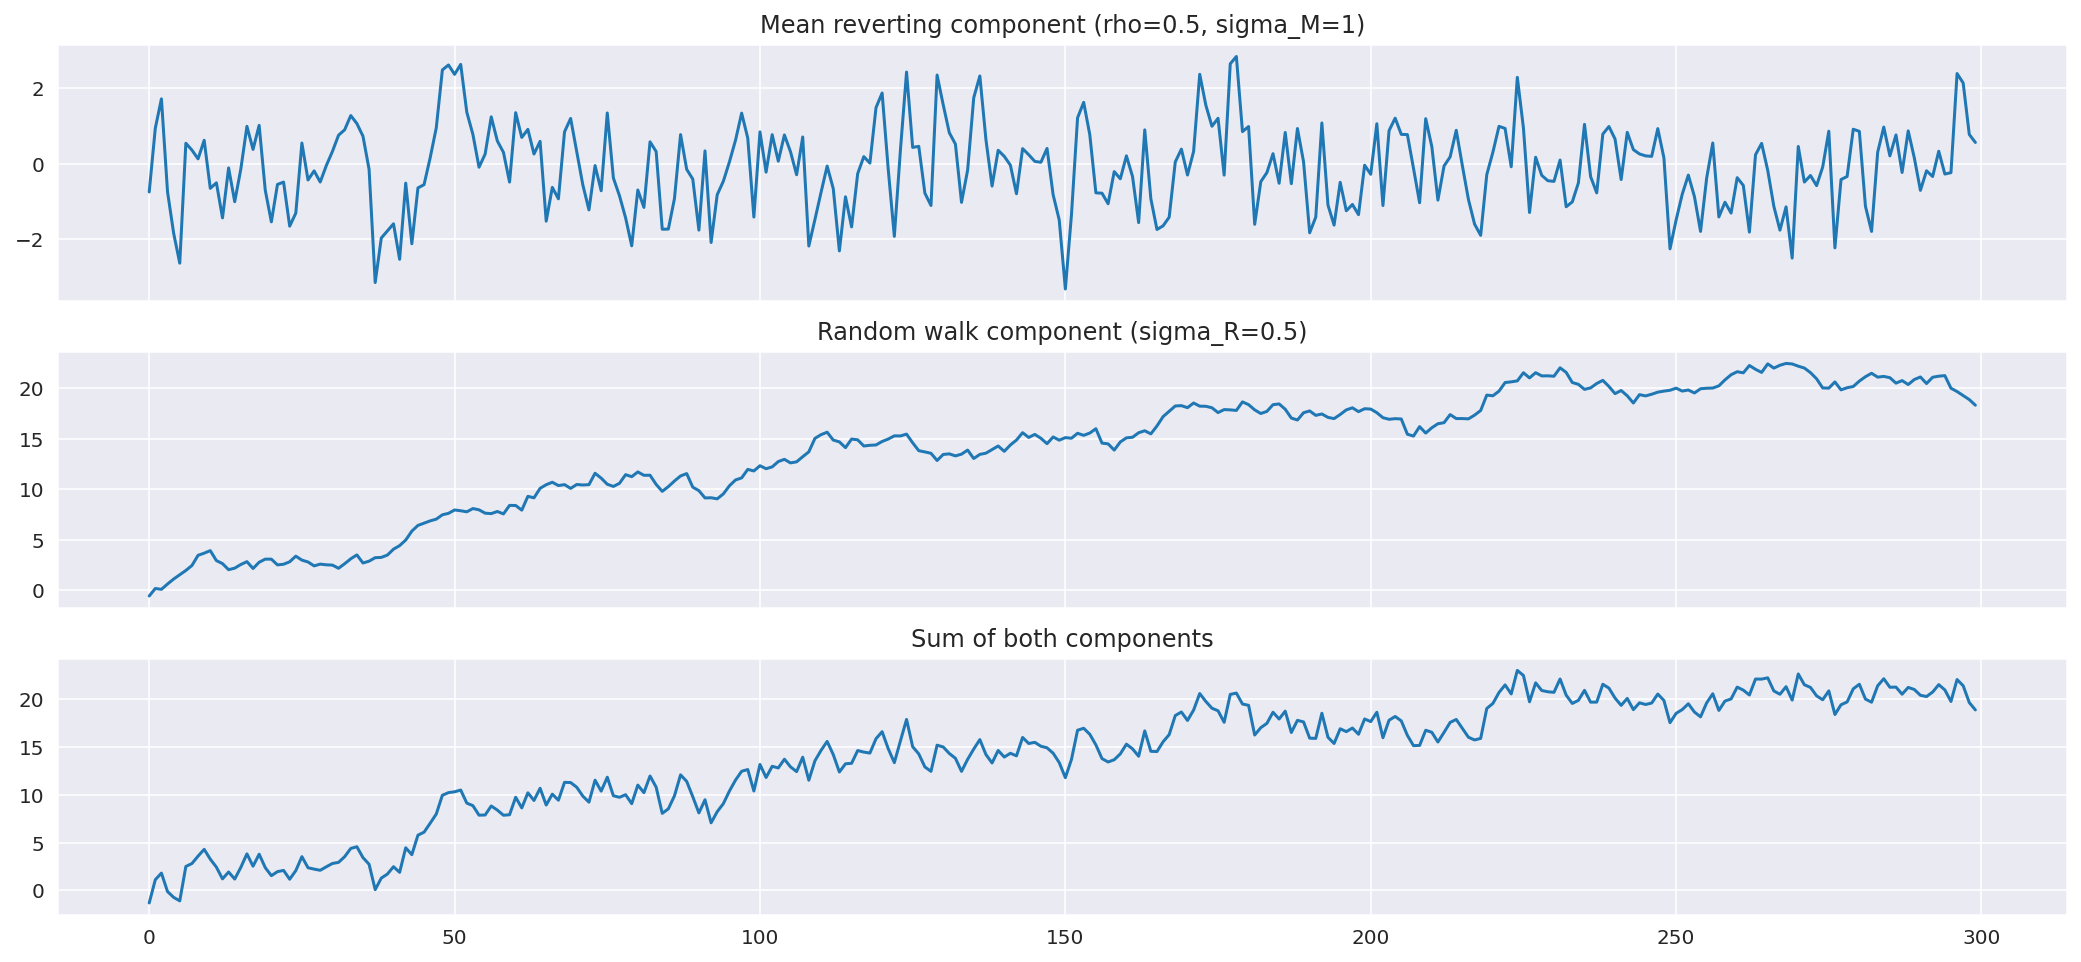

In [5]:
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(18,8), sharex=True)
ax1.plot(M)
ax1.set_title(f'Mean reverting component (rho={rho}, sigma_M={sigma_M})')
ax2.plot(R)
ax2.set_title(f'Random walk component (sigma_R={sigma_R})')
ax3.plot(X)
ax3.set_title('Sum of both components')

In [6]:
np.std(np.diff(R)) # sigma_R

0.4910008106257636

In [7]:
np.std(M[1:] - rho*M[:-1]) # sigma_M

1.0165856295123856

In [8]:
# proportion of variance attributable to mean reversion
(2*sigma_M**2) / (2*sigma_M**2 + (1+rho) * sigma_R**2)

0.8421052631578947

In [9]:
def generate_par(N, rho, sigma_M, sigma_R):
    '''
    Generate PAR sample of length N with parameters rho, sigma_M, sigma_R
    '''
    from statsmodels.tsa.arima_process import arma_generate_sample
    
    ar_M = np.r_[1, -rho]
    ar_R = np.r_[1, -1]
    ma = np.r_[1]

    M = arma_generate_sample(ar_M, ma, N, scale=sigma_M)
    R = arma_generate_sample(ar_R, ma, N, scale=sigma_R)
    
    return M+R

In [10]:
def calculate_Rsq(rho, sigma_M, sigma_R):
    '''
    Calculate R^2 - proportion of variance attributable to mean reversion
    '''    
    return (2*sigma_M**2) / (2*sigma_M**2 + (1+rho) * sigma_R**2)

# Estimate parameters using lagged variances

In [11]:
# generate a sample
N = 2500
sigma_M = 1
sigma_R = 0.5
rho = 0.5

np.random.seed(44)
X = generate_par(N, rho, sigma_M, sigma_R)

In [12]:
# calculate lagged variances
v1 = np.var(X[1:] - X[:-1])
v2 = np.var(X[2:] - X[:-2])
v3 = np.var(X[3:] - X[:-3])

In [13]:
# rho
rho_lv = -(v1 - 2*v2 + v3) / (2*v1 - v2)
rho_lv

0.5310977377515682

In [14]:
# sigma_M
sigma_M_lv = np.sqrt(1/2 * (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1))
sigma_M_lv

1.0296704460001678

In [15]:
# sigma_R
sigma_R_lv = np.sqrt(1/2 * (v2 - 2*sigma_M_lv**2))    
sigma_R_lv

0.4254865860508296

In [16]:
def lagvar_estimate_par(X):
    '''
    estimate parameters of partial AR model using lagged variances
    '''
    
    # calculate lagged variances
    v1 = np.var(X[1:] - X[:-1])
    v2 = np.var(X[2:] - X[:-2])
    v3 = np.var(X[3:] - X[:-3])
    
    # rho
    rho_lv = -(v1 - 2*v2 + v3) / (2*v1 - v2)
    
    # sigma_M
    if (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1) > 0:
        sigma_M_lv = np.sqrt(1/2 * (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1))
    else:
        sigma_M_lv = 0
        
    # sigma_R
    if v2 > 2*sigma_M_lv**2:
        sigma_R_lv = np.sqrt(1/2 * (v2 - 2*sigma_M_lv**2))
    else:
        sigma_R_lv = 0
    
    return rho_lv, sigma_M_lv, sigma_R_lv

In [17]:
def lagvar_estimate_rw(X):
    '''
    estimate parameters of randow walk model using lagged variances
    '''
    
    # calculate lagged variances
    v1 = np.var(X[1:] - X[:-1])
    v2 = np.var(X[2:] - X[:-2])
    v3 = np.var(X[3:] - X[:-3])
    
    # rho
    rho_lv = 0
    # sigma_M
    sigma_M_lv = 0
    # sigma_R
    sigma_R_lv = np.sqrt(1/2 * (v2 - 2*sigma_M_lv**2))
    
    return sigma_R_lv

In [18]:
def lagvar_estimate_ar(X):
    '''
    estimate parameters of AR model using lagged variances
    '''
    
    # calculate lagged variances
    v1 = np.var(X[1:] - X[:-1])
    v2 = np.var(X[2:] - X[:-2])
    v3 = np.var(X[3:] - X[:-3])
    
    # rho
    rho_lv = -(v1 - 2*v2 + v3) / (2*v1 - v2)
    # sigma_M
    if (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1) > 0:
        sigma_M_lv = np.sqrt(1/2 * (rho_lv+1) / (rho_lv-1) * (v2 - 2*v1))
    else:
        sigma_M_lv = 0
    
    return rho_lv, sigma_M_lv

# Estimating parameters with MLE

In [19]:
def kalman_estimate(X, rho, sigma_M, sigma_R):
    '''
    Calculate estimates of mean-reverting and random walk components
    '''
    
    # create arrays for storing both components and prediction errors
    M = np.zeros(len(X))
    R = np.zeros(len(X))
    eps = np.zeros(len(X))
    
    # set initial state
    if sigma_R==0:
        M[0] = X[0]
        R[0] = 0
    else:
        M[0] = 0
        R[0] = X[0]
    
    # calculate Kalman gain    
    if sigma_M==0:
        K_M = 0
        K_R = 1
    elif sigma_R==0:
        K_M = 1
        K_R = 0
    else:
        sqr = np.sqrt((1+rho)**2 * sigma_R**2 + 4*sigma_M**2)
        K_M = 2*sigma_M**2 / (sigma_R * (sqr + rho*sigma_R + sigma_R) + 2*sigma_M**2)
        K_R = 2*sigma_R / (sqr - rho*sigma_R + sigma_R)
    
    # calculate estimates
    for i in range(1, len(X)):
        xhat = rho * M[i-1] + R[i-1]
        eps[i] = X[i] - xhat
        M[i] = rho * M[i-1] + eps[i] * K_M
        R[i] = R[i-1] + eps[i] * K_R
        
    return M, R, eps

In [20]:
M_est, R_est, eps = kalman_estimate(X, 0.7, 1, 0.3)

In [21]:
def log_like(X, rho, sigma_M, sigma_R):
    '''
    Compute log likelihood function
    '''
    
    N = len(X)
    _,_,eps = kalman_estimate(X, rho, sigma_M, sigma_R)
    ll = -(N-1)/2 * np.log(2*np.pi * (sigma_M**2 + sigma_R**2)) - 1 / (2 * (sigma_M**2 + sigma_R**2)) * np.sum(eps[1:]**2)
    
    return ll

In [22]:
log_like(X, 0.7, 1, 0.3)

-4043.0071158041537

In [23]:
def f_to_min_par(parameters, X):
    rho, sigma_M, sigma_R = parameters
    return -log_like(X, rho, sigma_M, sigma_R)

def f_to_min_rw(sigma_R, X):
    rho = 0
    sigma_M = 0 # remove mean-reverting component
    return -log_like(X, rho, sigma_M, sigma_R)

def f_to_min_ar(parameters, X):
    rho, sigma_M = parameters
    sigma_R = 0 # remove random walk component
    return -log_like(X, rho, sigma_M, sigma_R)

In [24]:
# generate a sample
N = 250
rho = 0.7
sigma_M = 1
sigma_R = 0.5

np.random.seed(11)
X = generate_par(N, rho, sigma_M, sigma_R)

In [25]:
rho_lv, sigma_M_lv, sigma_R_lv = lagvar_estimate_par(X)
print(rho_lv, sigma_M_lv, sigma_R_lv)

0.456889197696379 0.6919248220826052 0.7965348709773407


In [26]:
from scipy.optimize import minimize

minimize(f_to_min_par, (rho_lv, sigma_M_lv, sigma_R_lv), args=(X),
         bounds=((-1,1), (0,np.inf), (0,np.inf)), tol=0.001)

      fun: 380.9134029123813
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.81065047, -0.46545665,  3.13200984])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 2
     njev: 4
   status: 0
  success: True
        x: array([0.46223886, 0.74599543, 0.83852531])

In [27]:
minimize(f_to_min_rw, (sigma_R_lv), args=(X))

      fun: 385.28226986727634
 hess_inv: array([[0.00259537]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 8
     njev: 14
   status: 0
  success: True
        x: array([1.13698476])

In [28]:
minimize(f_to_min_ar, (rho_lv, sigma_M_lv), args=(X))

      fun: 383.23981479329143
 hess_inv: array([[3.15995463e-04, 1.60756326e-06],
       [1.60756326e-06, 2.55424202e-03]])
      jac: array([-3.81469727e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 12
     njev: 15
   status: 0
  success: True
        x: array([0.96356424, 1.12769664])

In [33]:
from scipy import stats

def mle_fit(X, mode, tol=0.001):
    '''
    fit model using MLE
    '''
    
    estimates = []
    lls = []
    
    # distribution for random guesses
    rnd_rho = stats.uniform(loc=-1, scale=2)
    
    if mode=='PAR':
        # get initial guesses using lagged variances
        x0 = lagvar_estimate_par(X)
        # set boundaries
        bounds = ((-1,1), (0,np.inf), (0,np.inf))
        # function to use in minimization
        f_to_min = f_to_min_par
        # function to generate random initial values
        std = np.std(np.diff(X))
        rnd_sigma = stats.norm(loc=std, scale=std/2)
        def gen_x0():
            return rnd_rho.rvs(), rnd_sigma.rvs(), rnd_sigma.rvs()
        
    elif mode=='AR':
        x0 = lagvar_estimate_ar(X)
        bounds = ((-1,1), (0,np.inf))
        f_to_min = f_to_min_ar
        std = np.std(np.diff(X))
        rnd_sigma = stats.norm(loc=std, scale=std/2)
        def gen_x0():
            return rnd_rho.rvs(), rnd_sigma.rvs()
        
    elif mode=='RW':
        x0 = lagvar_estimate_rw(X)
        bounds = ((0,np.inf),)
        f_to_min = f_to_min_rw
        std = np.std(np.diff(X))
        rnd_sigma = stats.norm(loc=std, scale=std/2)
        def gen_x0():
            return rnd_sigma.rvs()
    
    # minimize
    res = minimize(f_to_min, (x0), args=(X), bounds=bounds, tol=tol)
    
    if res.success:
        estimates.append(res.x)
        lls.append(-res.fun) # save log-likelihood
    
    # repeat minimization with different (random) initial values
    n_att = 0
    while len(lls)<10 and n_att<100: 
        n_att += 1
        x0 = gen_x0()
        res = minimize(f_to_min, (x0), args=(X), bounds=bounds, tol=tol)
        if res.success:
            estimates.append(res.x)
            lls.append(-res.fun) # save log-likelihood
    
    try:
        argmax = np.argmax(lls) # index of the biggest likelihood
        return estimates[argmax]
    except:
        #print('Estimation failed!')
        return len(x0)*[np.nan] # return nans

## PAR mode + PAR sample

In [34]:
rho = 0.7
sigma_M = 1
sigma_R = 0.5

In [35]:
# proportion of variance attributable to mean reversion
(2*sigma_M**2) / (2*sigma_M**2 + (1+rho) * sigma_R**2)

0.8247422680412372

In [36]:
from tqdm import tqdm

rhos = []
sigmaMs = []
sigmaRs = []
N_sim = 1000
N = 500

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for i in tqdm(range(N_sim)):
        np.random.seed(i)
        sample = generate_par(N, rho, sigma_M, sigma_R)
        params = mle_fit(sample, mode='PAR')
        rhos.append(params[0])
        sigmaMs.append(params[1])
        sigmaRs.append(params[2])

100%|██████████| 1000/1000 [04:54<00:00,  3.40it/s]


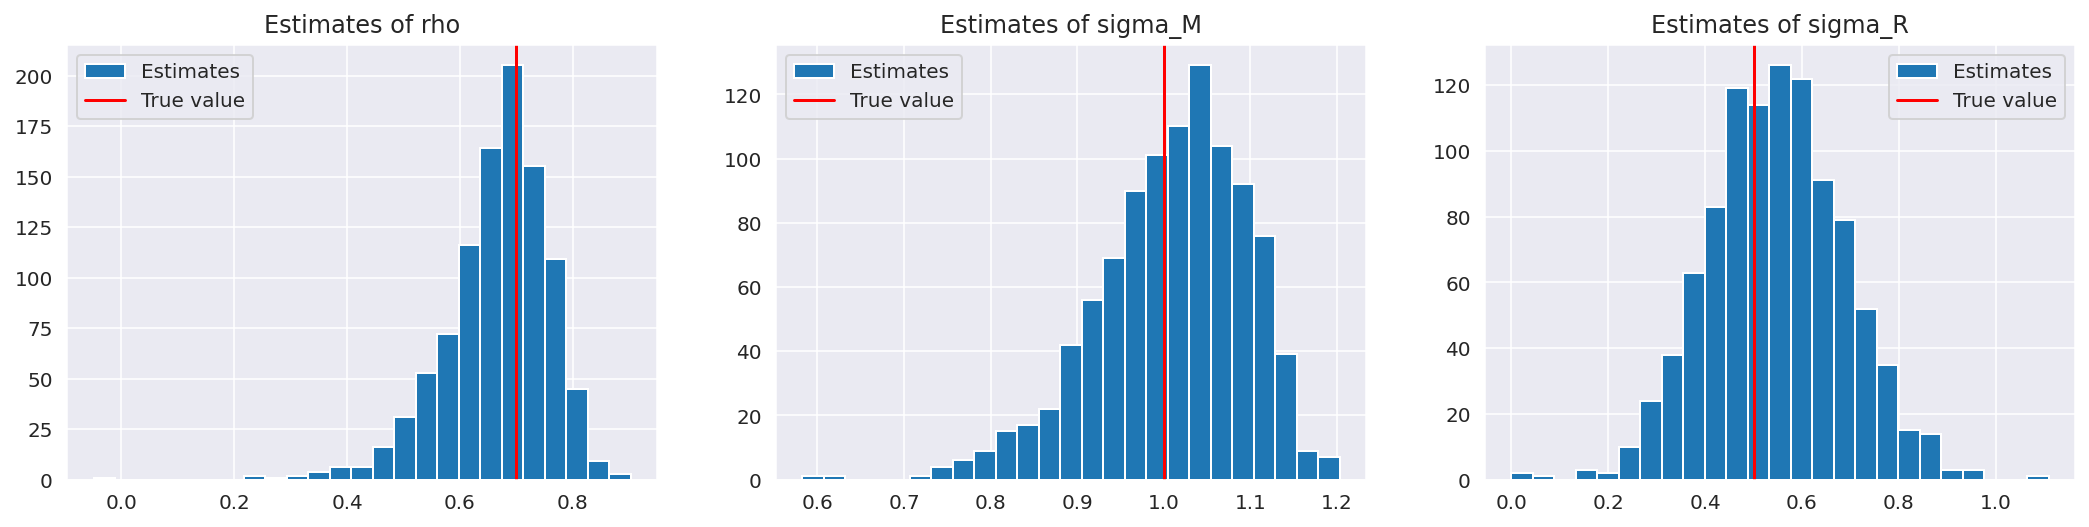

In [37]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18,4))
ax1.hist(rhos, bins=25, label='Estimates')
ax1.set_title('Estimates of rho')
ax1.axvline(x=rho, label='True value', c='r')
ax1.legend()
ax2.hist(sigmaMs, bins=25, label='Estimates')
ax2.set_title('Estimates of sigma_M')
ax2.axvline(x=sigma_M, label='True value', c='r')
ax2.legend()
ax3.hist(sigmaRs, bins=25, label='Estimates')
ax3.set_title('Estimates of sigma_R')
ax3.axvline(x=sigma_R, label='True value', c='r')
ax3.legend()

## PAR mode + AR sample

In [38]:
sigma_M = 1
sigma_R = 0
rho = 0.7

In [39]:
rhos = []
sigmaMs = []
sigmaRs = []
N_sim = 1000
N = 500

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for i in tqdm(range(N_sim)):
        np.random.seed(i)
        sample = generate_par(N, rho, sigma_M, sigma_R)
        params = mle_fit(sample, mode='PAR')
        rhos.append(params[0])
        sigmaMs.append(params[1])
        sigmaRs.append(params[2])

100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


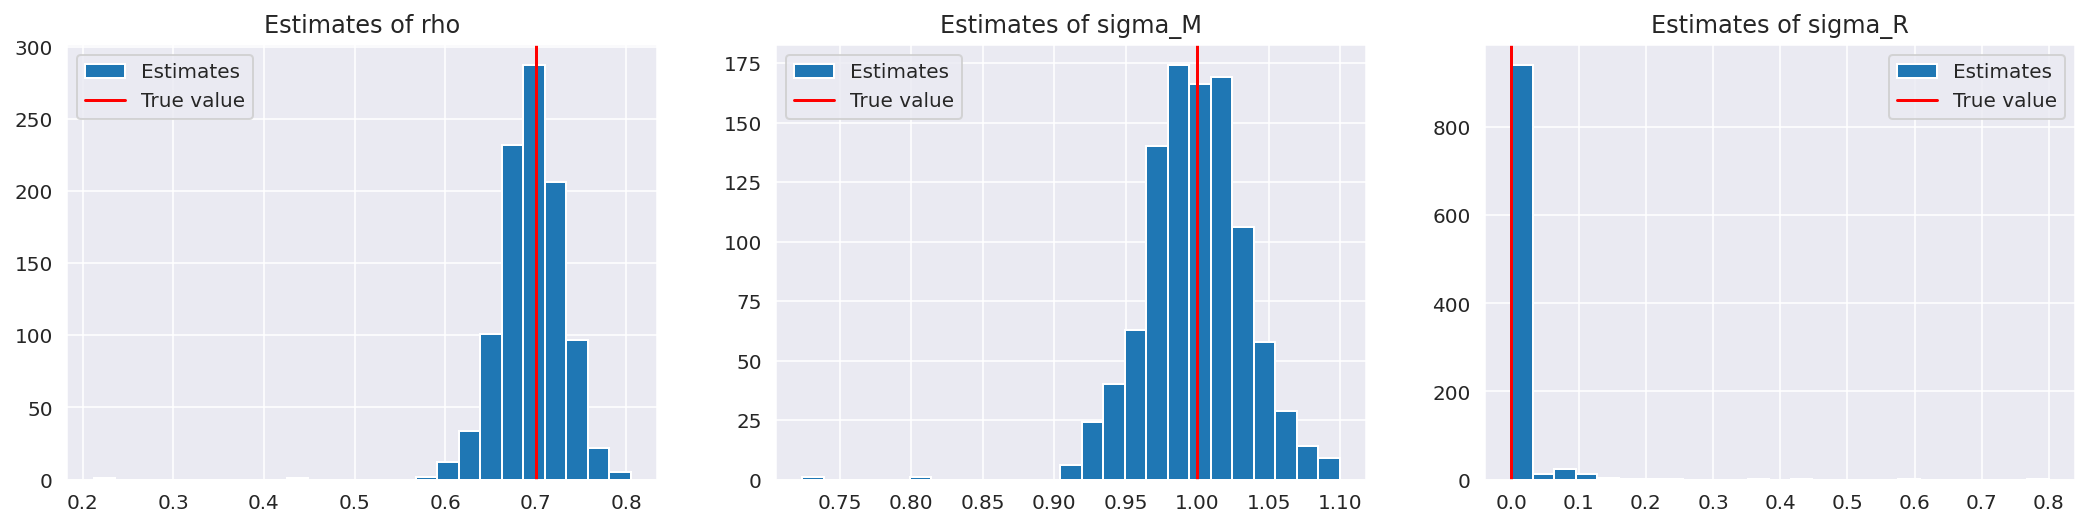

In [40]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18,4))
ax1.hist(rhos, bins=25, label='Estimates')
ax1.set_title('Estimates of rho')
ax1.axvline(x=rho, label='True value', c='r')
ax1.legend()
ax2.hist(sigmaMs, bins=25, label='Estimates')
ax2.set_title('Estimates of sigma_M')
ax2.axvline(x=sigma_M, label='True value', c='r')
ax2.legend()
ax3.hist(sigmaRs, bins=25, label='Estimates')
ax3.set_title('Estimates of sigma_R')
ax3.axvline(x=sigma_R, label='True value', c='r')
ax3.legend()

## AR mode + AR sample

In [41]:
sigma_M = 1
sigma_R = 0
rho = 0.7

In [42]:
rhos = []
sigmaMs = []
N_sim = 1000
N = 500

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for i in tqdm(range(N_sim)):
        np.random.seed(i)
        sample = generate_par(N, rho, sigma_M, sigma_R)
        params = mle_fit(sample, mode='AR')
        rhos.append(params[0])
        sigmaMs.append(params[1])

100%|██████████| 1000/1000 [04:52<00:00,  3.42it/s]


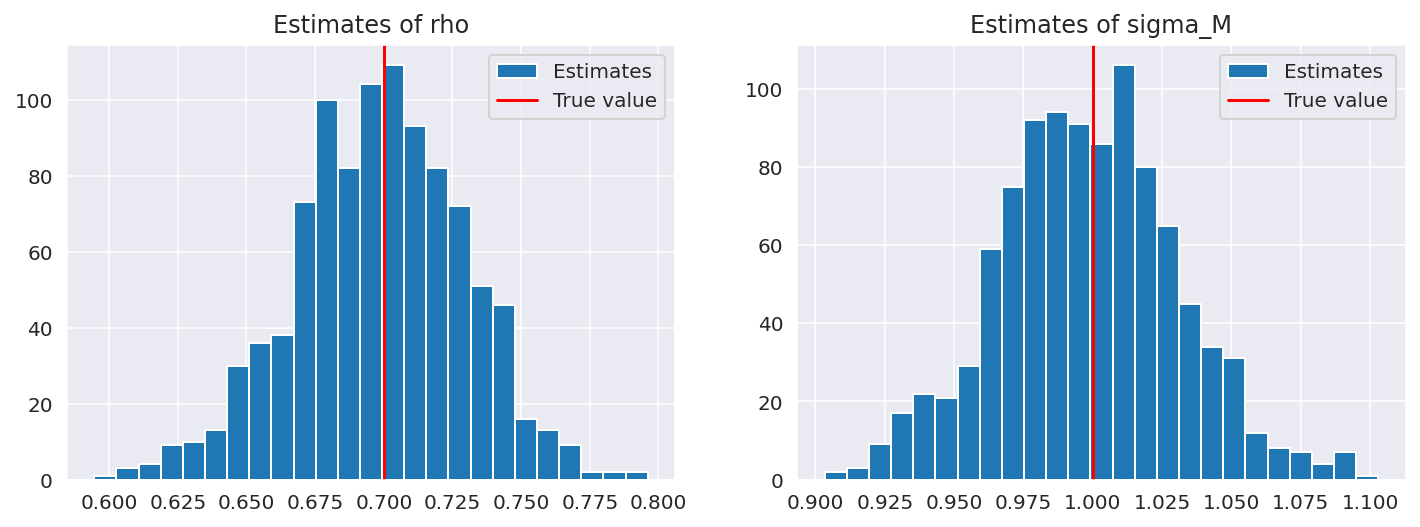

In [43]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.hist(rhos, bins=25, label='Estimates')
ax1.set_title('Estimates of rho')
ax1.axvline(x=rho, label='True value', c='r')
ax1.legend()
ax2.hist(sigmaMs, bins=25, label='Estimates')
ax2.set_title('Estimates of sigma_M')
ax2.axvline(x=sigma_M, label='True value', c='r')
ax2.legend()

## RW mode + RW sample

In [44]:
sigma_M = 0
sigma_R = 1
rho = 0

In [45]:
sigmaRs = []
N_sim = 1000
N = 500

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for i in tqdm(range(N_sim)):
        np.random.seed(i)
        sample = generate_par(N, rho, sigma_M, sigma_R)
        params = mle_fit(sample, mode='RW')
        sigmaRs.append(params[0])

100%|██████████| 1000/1000 [02:09<00:00,  7.71it/s]


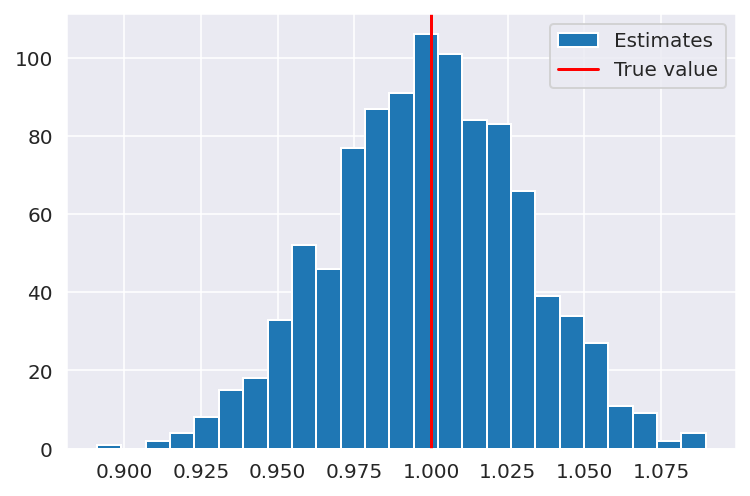

In [46]:
plt.hist(sigmaRs, bins=25, label='Estimates')
plt.axvline(x=sigma_R, label='True value', c='r')
plt.legend()

# Likelihood ratio test

## RW samples + RW null

In [47]:
rho = 0
sigma_M = 0
sigma_R = 1

n_sim = 1000
n_samples = 2500

lambdas = []

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for i in tqdm(range(n_sim)):
        np.random.seed(i)
        sample = generate_par(n_samples, rho, sigma_M, sigma_R)

        # log likelihood of RW
        sigmaR_rw = mle_fit(sample, mode='RW')
        ll_rw = log_like(sample, 0, 0, sigmaR_rw)

        # log likelihood of PAR
        rho_par, sigmaM_par, sigmaR_par = mle_fit(sample, mode='PAR')
        ll_par = log_like(sample, rho_par, sigmaM_par, sigmaR_par)

        lambdas.append(ll_rw - ll_par)

100%|██████████| 1000/1000 [28:50<00:00,  1.73s/it]


In [48]:
lambdas = np.array(lambdas)

In [49]:
np.quantile(lambdas, [0.01, 0.05, 0.1])

array([-3.6355796 , -2.37553225, -1.73262375])

(array([  2.,   2.,   3.,   0.,   3.,   1.,   7.,   6.,  11.,  10.,  11.,
         18.,  28.,  24.,  22.,  50.,  68.,  98., 133., 483.,  11.,   5.,
          3.,   0.,   1.]),
 array([-5.12189218, -4.85870898, -4.59552578, -4.33234259, -4.06915939,
        -3.8059762 , -3.542793  , -3.2796098 , -3.01642661, -2.75324341,
        -2.49006022, -2.22687702, -1.96369382, -1.70051063, -1.43732743,
        -1.17414424, -0.91096104, -0.64777785, -0.38459465, -0.12141145,
         0.14177174,  0.40495494,  0.66813813,  0.93132133,  1.19450453,
         1.45768772]),
 <BarContainer object of 25 artists>)

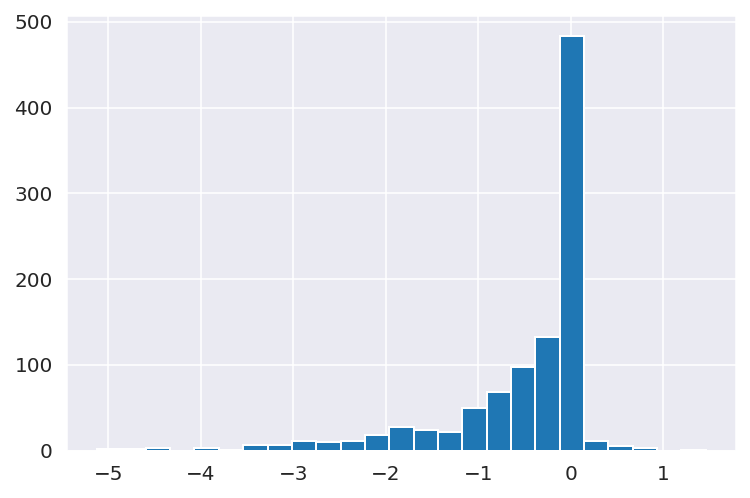

In [50]:
plt.hist(lambdas, bins=25)

In [51]:
np.quantile(lambdas[lambdas<0], [0.01, 0.05, 0.1])

array([-4.03885328, -2.73686515, -1.99006283])

# PAR with real data

In [52]:
data = pd.read_csv('vbr0214.csv', index_col=0)
data

,IEX,NUAN,MOH,NVAX,SBNY,PWR,WSM,FANG,BRO,STLD,...,RES,LE,APEI,FF,WK,PKI,ALGT,SAGE,OII,DRQ
2002-01-02,11.232835,3.852814,NaN,272.4,NaN,15.865090,14.170295,NaN,5.453000,1.985875,...,1.702178,NaN,NaN,NaN,NaN,28.196012,NaN,NaN,4.741946,11.250
2002-01-03,11.397299,4.017316,NaN,266.0,NaN,15.489702,14.335989,NaN,5.505086,1.968888,...,1.726847,NaN,NaN,NaN,NaN,28.872910,NaN,NaN,4.810350,11.220
2002-01-04,11.420323,4.329004,NaN,263.0,NaN,15.628003,14.525847,NaN,5.639308,1.999466,...,1.717966,NaN,NaN,NaN,NaN,29.187184,NaN,NaN,4.843449,11.095
2002-01-07,11.364406,4.458874,NaN,263.0,NaN,15.786061,14.553462,NaN,5.450997,2.038538,...,1.697244,NaN,NaN,NaN,NaN,28.244362,NaN,NaN,4.836829,11.600
2002-01-08,11.486109,4.701299,NaN,264.8,NaN,15.282250,14.646665,NaN,5.298745,2.106489,...,1.726847,NaN,NaN,NaN,NaN,28.204070,NaN,NaN,4.841242,11.550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-24,65.672753,13.281385,33.51,101.6,101.676034,30.781831,47.746814,48.685599,14.144676,15.915873,...,16.556145,NaN,45.01,7.194574,NaN,39.724403,95.280130,NaN,71.823160,110.660
2013-12-26,66.103865,13.090909,33.12,102.6,101.638345,30.910253,47.877896,49.350089,14.057871,15.899431,...,16.464421,NaN,44.30,7.140138,NaN,39.685760,96.335122,NaN,71.695100,110.910
2013-12-27,66.032013,12.926407,33.21,102.6,101.421632,30.949767,47.886089,49.920989,14.117264,16.285818,...,16.565318,NaN,43.52,7.180965,NaN,39.782366,93.179086,NaN,71.768277,111.110
2013-12-30,65.933217,12.995671,33.98,103.2,100.884561,30.831224,48.213795,48.601368,14.194931,16.046078,...,16.519456,NaN,43.07,7.149211,NaN,39.946597,94.108909,NaN,71.685953,109.420


## Prices

In [ ]:
start_years = [2002, 2004, 2006, 2008, 2010, 2012]
columns = ['AIC_AR', 'AIC_RW', 'AIC_PAR', 'rho', 'sigma_M', 'sigma_R', '$R^2_{MR}$']
results = {}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for sy in start_years:
        print(f'Processing years {sy}-{sy+1}')
        data_tmp = data.loc[f'{sy}-01-01':f'{sy+2}-01-01']
        data_tmp = data_tmp.dropna(axis=1)
        results_df = pd.DataFrame(columns=columns, index=data_tmp.columns)

        for s in tqdm(data_tmp.columns):
            X = data_tmp[s].values

            # fit PAR
            rho_par, sigmaM_par, sigmaR_par = mle_fit(X, mode='PAR')
            ll_par = log_like(X, rho_par, sigmaM_par, sigmaR_par)
            aic_par = 2*3 - 2*ll_par

            # fit AR
            rho_ar, sigmaM_ar = mle_fit(X, mode='AR')
            ll_ar = log_like(X, rho_ar, sigmaM_ar, 0)
            aic_ar = 2*2 - 2*ll_ar

            # fit RW
            sigmaR_rw = mle_fit(X, mode='RW')
            ll_rw = log_like(X, 0, 0, sigmaR_rw)
            aic_rw = 2*1 - 2*ll_rw

            # calculate R^2
            r_sq = calculate_Rsq(rho_par, sigmaM_par, sigmaR_par)

            results_df.loc[s] = [aic_ar, aic_rw, aic_par, rho_par, sigmaM_par, sigmaR_par, r_sq]

        results[sy] = results_df

Processing years 2002-2003


100%|██████████| 465/465 [26:01<00:00,  3.36s/it]


Processing years 2004-2005


100%|██████████| 495/495 [23:42<00:00,  2.87s/it]


Processing years 2006-2007


100%|██████████| 525/525 [20:27<00:00,  2.34s/it]


Processing years 2008-2009


100%|██████████| 575/575 [21:07<00:00,  2.20s/it]


Processing years 2010-2011


100%|██████████| 596/596 [23:33<00:00,  2.37s/it]


Processing years 2012-2013


  3%|▎         | 19/628 [00:46<31:27,  3.10s/it]

In [60]:
sum_ind = ['2002-2003', '2004-2005', '2006-2007', '2008-2009', '2010-2011', '2012-2013']
sum_col = ['N', 'P_ar', 'P_rw', 'P_par', '$\overline{\rho}$', '$\overline{R}^2_{MR}$']
sum_df = pd.DataFrame(index=sum_ind, columns=sum_col)
sum_df

,N,P_ar,P_rw,P_par,$\overline{\rho}$,$\overline{R}^2_{MR}$
2002-2003,NaN,NaN,NaN,NaN,NaN,NaN
2004-2005,NaN,NaN,NaN,NaN,NaN,NaN
2006-2007,NaN,NaN,NaN,NaN,NaN,NaN
2008-2009,NaN,NaN,NaN,NaN,NaN,NaN
2010-2011,NaN,NaN,NaN,NaN,NaN,NaN
2012-2013,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
for sy in start_years:
    res = results[sy]
    N = len(res)
    cond_ar = (res['AIC_AR'] == res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    cond_rw = (res['AIC_RW'] == res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    cond_par = (res['AIC_PAR'] == res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    P_ar = len(res[cond_ar]) / N
    P_rw = len(res[cond_rw]) / N
    P_par = len(res[cond_par]) / N
    rho_bar = res[cond_par]['rho'].mean()
    rsq_bar = res[cond_par]['$R^2_{MR}$'].mean()
    sum_df.loc[f'{sy}-{sy+1}'] = [N, P_ar, P_rw, P_par, rho_bar, rsq_bar]

In [62]:
sum_df

,N,P_ar,P_rw,P_par,$\overline{\rho}$,$\overline{R}^2_{MR}$
2002-2003,465,0.027957,0.584946,0.387097,0.065974,0.37766
2004-2005,495,0.028283,0.666667,0.305051,0.136103,0.368734
2006-2007,525,0.028571,0.592381,0.379048,0.464074,0.504158
2008-2009,575,0.12,0.41913,0.46087,0.201295,0.422426
2010-2011,596,0.010067,0.528523,0.461409,-0.129947,0.303954
2012-2013,628,0.004777,0.845541,0.149682,-0.021865,0.301145


In [63]:
sum_df.mean()

N                        547.333333
P_ar                       0.036609
P_rw                       0.606198
P_par                      0.357193
$\overline{\rho}$          0.119272
$\overline{R}^2_{MR}$      0.379680
dtype: float64

In [64]:
per_col = ['$N$', '$A_{t}$', '$A_{t-1}$', '$A_{t}|A_{t-1}$', '$p_t$', '$p_{t|t-1}$']
per_ind = sum_ind[1:]

per_df = pd.DataFrame(index=per_ind, columns=per_col)

for i in range(1,len(start_years)):
    cur_res = results[start_years[i]]
    prev_res = results[start_years[i-1]]
    N = len(cur_res)
    
    # calculate A_t
    cond = (cur_res['AIC_PAR'] == cur_res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    cur_symbols = cur_res[cond].index # stocks that are PAR in current period
    at0 = len(cur_symbols)
    
    # calculaye A_{t-1}
    cond = (prev_res['AIC_PAR'] == prev_res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    prev_symbols = prev_res[cond].index # stocks that are PAR in previous period
    at1 = len(prev_symbols)
    
    # calculate A_{t}|A_{t-1}
    symbols_is = set(cur_symbols).intersection(set(prev_symbols))
    at_is = len(symbols_is)
    
    p0 = at0 / N
    p1 = at_is / at1
    
    sy = start_years[i]
    per_df.loc[f'{sy}-{sy+1}'] = [N, at0, at1, at_is, p0, p1]

In [65]:
print(per_df)

           $N$ $A_{t}$ $A_{t-1}$ $A_{t}|A_{t-1}$     $p_t$ $p_{t|t-1}$
2004-2005  495     151       180              88  0.305051    0.488889
2006-2007  525     199       151              92  0.379048    0.609272
2008-2009  575     265       199             133   0.46087    0.668342
2010-2011  596     275       265             170  0.461409    0.641509
2012-2013  628      94       275              60  0.149682    0.218182


## Log prices

In [67]:
results_log = {}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for sy in start_years:
        print(f'Processing years {sy}-{sy+1}')
        data_tmp = data.loc[f'{sy}-01-01':f'{sy+2}-01-01']
        data_tmp = data_tmp.dropna(axis=1)
        results_df = pd.DataFrame(columns=columns, index=data_tmp.columns)

        for s in tqdm(data_tmp.columns):
            X = np.log(data_tmp[s].values)

            # fit PAR
            rho_par, sigmaM_par, sigmaR_par = mle_fit(X, mode='PAR')
            ll_par = log_like(X, rho_par, sigmaM_par, sigmaR_par)
            aic_par = 2*3 - 2*ll_par

            # fit AR
            rho_ar, sigmaM_ar = mle_fit(X, mode='AR')
            ll_ar = log_like(X, rho_ar, sigmaM_ar, 0)
            aic_ar = 2*2 - 2*ll_ar

            # fit RW
            sigmaR_rw = mle_fit(X, mode='RW')
            ll_rw = log_like(X, 0, 0, sigmaR_rw)
            aic_rw = 2*1 - 2*ll_rw

            # calculate R^2
            r_sq = calculate_Rsq(rho_par, sigmaM_par, sigmaR_par)

            results_df.loc[s] = [aic_ar, aic_rw, aic_par, rho_par, sigmaM_par, sigmaR_par, r_sq]

        results_log[sy] = results_df

Processing years 2002-2003


100%|██████████| 465/465 [40:05<00:00,  5.17s/it]


Processing years 2004-2005


100%|██████████| 495/495 [45:25<00:00,  5.51s/it]


Processing years 2006-2007


100%|██████████| 525/525 [48:40<00:00,  5.56s/it]


Processing years 2008-2009


100%|██████████| 575/575 [48:50<00:00,  5.10s/it]


Processing years 2010-2011


100%|██████████| 596/596 [54:07<00:00,  5.45s/it]


Processing years 2012-2013


100%|██████████| 628/628 [58:49<00:00,  5.62s/it]


In [68]:
logsum_df = pd.DataFrame(index=sum_ind, columns=sum_col)
logsum_df

for sy in start_years:
    res = results_log[sy]
    N = len(res)
    cond_ar = (res['AIC_AR'] == res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    cond_rw = (res['AIC_RW'] == res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    cond_par = (res['AIC_PAR'] == res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    P_ar = len(res[cond_ar]) / N
    P_rw = len(res[cond_rw]) / N
    P_par = len(res[cond_par]) / N
    rho_bar = res[cond_par]['rho'].mean()
    rsq_bar = res[cond_par]['$R^2_{MR}$'].mean()
    logsum_df.loc[f'{sy}-{sy+1}'] = [N, P_ar, P_rw, P_par, rho_bar, rsq_bar]

In [69]:
logsum_df

,N,P_ar,P_rw,P_par,$\overline{\rho}$,$\overline{R}^2_{MR}$
2002-2003,465,0.015054,0.604301,0.380645,-0.056082,0.343914
2004-2005,495,0.012121,0.715152,0.272727,0.124042,0.37866
2006-2007,525,0.011429,0.659048,0.329524,0.41393,0.457518
2008-2009,575,0.010435,0.546087,0.443478,0.189164,0.412758
2010-2011,596,0.006711,0.543624,0.449664,-0.192785,0.277766
2012-2013,628,0.0,0.866242,0.133758,0.05412,0.311417


In [70]:
logsum_df.mean()

N                        547.333333
P_ar                       0.009292
P_rw                       0.655742
P_par                      0.334966
$\overline{\rho}$          0.088731
$\overline{R}^2_{MR}$      0.363672
dtype: float64

In [71]:
logper_col = ['$N$', '$A_{t}$', '$A_{t-1}$', '$A_{t}|A_{t-1}$', '$p_t$', '$p_{t|t-1}$']
logper_ind = sum_ind[1:]

logper_df = pd.DataFrame(index=per_ind, columns=per_col)

for i in range(1,len(start_years)):
    cur_res = results_log[start_years[i]]
    prev_res = results_log[start_years[i-1]]
    N = len(cur_res)
    
    # calculate A_t
    cond = (cur_res['AIC_PAR'] == cur_res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    cur_symbols = cur_res[cond].index # stocks that are PAR in current period
    at0 = len(cur_symbols)
    
    # calculaye A_{t-1}
    cond = (prev_res['AIC_PAR'] == prev_res[['AIC_AR', 'AIC_RW', 'AIC_PAR']].min(axis=1))
    prev_symbols = prev_res[cond].index # stocks that are PAR in previous period
    at1 = len(prev_symbols)
    
    # calculate A_{t}|A_{t-1}
    symbols_is = set(cur_symbols).intersection(set(prev_symbols))
    at_is = len(symbols_is)
    
    p0 = at0 / N
    p1 = at_is / at1
    
    sy = start_years[i]
    logper_df.loc[f'{sy}-{sy+1}'] = [N, at0, at1, at_is, p0, p1]

In [73]:
print(logper_df)

           $N$ $A_{t}$ $A_{t-1}$ $A_{t}|A_{t-1}$     $p_t$ $p_{t|t-1}$
2004-2005  495     135       177              81  0.272727    0.457627
2006-2007  525     173       135              82  0.329524    0.607407
2008-2009  575     255       173             114  0.443478     0.65896
2010-2011  596     268       255             170  0.449664    0.666667
2012-2013  628      84       268              54  0.133758    0.201493
